# Part 2: Data Analytics 
(Raj Dhakan, xn23972)
***
[TODO: insert description of what the code in this file does]
***
## Importing Libraries

In [64]:
import json
import pandas as pd
import requests
import numpy as np
import time
from sigfig import round
# !pip install yfinance
import yfinance as yf
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

## Step 1: Crawling Real-World Datasets
***
The dataset that is extracted is about S&P500 stocks. S&P500 is a common equity indicies which include 500 of the largest companies listed on stock exchanges in the United States. 

First, the table of S&P500 companies is scraped from Wikipedia's __[S&P500 Companies](https://en.wikipedia.org/wiki/List_of_S%26P_500_companies)__ homepage. The columns of interest from this table are: ***Symbol*** of the stock (e.g. AAPL for Apple Inc.), ***Security*** (i.e. the company name), ***Global Industry Classification Standard*** (GICS, i.e. field of work such as Tech, Finance, Healthcare etc) sector, and ***Headquarters Location***. 

Second, common key features used in analysing stocks are scraped from __[Yahoo Finance](https://finance.yahoo.com/)__. The key features of interest are: ***Market Capitilisation***, ***Revenue***, ***Profit Margin***, ***Earning per Share***, ***Profit to Earnings ratio*** and ***Profit to Earning Growth ratio (5yr forecasted)***. These features are scraped by taking the symbols from the table acquired from Wikipedia and using them to create a url to the respective stock's statistics page (e.g. __https://finance.yahoo.com/quote/AAPL/key-statistics?p=AAPL__ for Apple Inc.)

The two tables are then merged and saved as `SnP500_raw.csv` in the directory of this jupyter notebook

<div class="alert alert-block alert-info">
<b>Note:</b> The data extracted from Yahoo Finance is accurate to date 08/12/2023.
</div>

<div class="alert alert-block alert-danger">
<b>Warning:</b> Running the below code will overwrite the raw_data file.
</div>

In [2]:
# # extracting list of SnP 500 companies from Wikipedia
# url_link= 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
# response = requests.get(url_link)
# SnP500_raw = pd.read_html(response.text)[0]
# SnP500_raw.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [3]:
# def yahoo_api_statistics(symbol:str):
#     '''
#     Returns a list of features commonly used to evaluate stocks.

#             Parameters:
#                     symbol (str): Stock symbols; e.g. AAPL for Apple

#             Returns:
#                     features_list (list): List of key features in the given order:
#                     1. Market Capitilisation (Market_cap)
#                     2. Revenue (Revenue)
#                     3. Profit Margin (Profit_margin)
#                     4. Earning per Share (EPS)
#                     5. Profit to Earnings ratio (PE_ratio)
#                     6. Profit to Earnings Growth ratio (PEG)
#     '''  
#     # replaces a '.' to '-' in any symbol to produce the correct url to scrape data
#     if "." in symbol:
#         symbol = symbol.replace(".","-")
        
#     statistics_url = ("https://finance.yahoo.com/quote/{symbol}/key-statistics?p={symbol}").format(symbol = symbol)
#     response = requests.get(statistics_url, headers= {'User-agent': 'Mozilla/5.0'})
#     df = pd.read_html(response.text)
    
#     # Extracts individual features from the tables (use of iat over iloc to increase speed of extraction)
#     Market_cap = df[0].iat[0,1]
#     Revenue = df[-3].iat[0,1]
#     Profit_margin = df[5].iat[0,1]
#     EPS = df[-3].iat[6,1]
#     PE_ratio =  df[0].iat[2,1]
#     PEG = df[0].iat[4,1]
    
#     features_list = [Market_cap, Revenue, Profit_margin, EPS, PE_ratio, PEG]
    
#     return features_list


# # creating an empty list to store the features
# features = []

# # loops through symbols to extract 
# for i in range(len(SnP500_raw)):
    
#     # try/except to catch out any pages with errors
#     try:
#         symbol = SnP500_raw.iat[i,0]
#         input_list = yahoo_api_statistics(symbol)
#         features.append(input_list)
#     except:
#         print(symbol)

In [4]:
# # columns with units, where B = Billions and TTM = Trailing Twelve Months
# columns_to_add = ['Market Cap / B', 'Revenue (TTM) / B', 'Profit Margin / %', 'Earnings per Share (TTM) / $', 'Price to Earning ratio (TTM)', 'Price to Earnings Growth ratio (5yr expected)']

# # converting lists of lists into a dataframe
# features = pd.DataFrame(data = features, columns = columns_to_add)

# # slicing the raw dataframe to acquire the required columns only 
# SnP500_sliced = SnP500_raw[['Symbol','Security','GICS Sector', 'Headquarters Location']]

# # merging the two dataframes
# SnP500_features_raw = pd.concat([SnP500_sliced,features], axis = 1)

# # saving the merged dataframe as csv file in the directory of this Jupyter Notebook
# SnP500_features_raw.to_csv("SnP500_raw_data.csv", index= False)

## Step 2: Data Preparation & Cleaning
***
The following is performed sequentially to prepare the data for analysis:
- Column headings are simplified where possible (e.g. ***Security*** is changed to ***Company***) to make it more understandable
- Column ***Headquarters Location*** is split into two columns, ***HQ Country*** and ***HQ State/City***. This because the initial column contain a mix of 'City,State,Country', 'State,Country' and 'City,Country'
- Missing values are identified and quantified for any columns with numeric values to create a logical strategy to clean data
    1. For columns, ***Market Cap***, ***Revenue***, ***Profit Margin***, and ***Earnings per Share***, any units with the value is removed and then rounded to 2 decimal places
    2. The list of companies is then ordered from the largest to smallest ***Market Cap***
    3. Column ***Price to Earnings Growth (5yr expected)*** is dropped due to having 1/5 of data points missing and the lack of raw data to calculate the ratio.
    4. Missing values in ***Price to Earnings ratio*** is filled by calculating from raw data using the formula:
        - `PE = current share price / (sum of EPS over the last 4 quarters)`
    5. ***Price to Earnings ratio*** values have their units removed if any, values are rounded to 2 decimal places, and any incorrect values are corrected (i.e. where PE ratio doesnt share the same sign as EPS, as illustrated by the equation)

In [36]:
# reading csv file
SnP500_raw_file_data = pd.read_csv("SnP500_raw_data.csv")
SnP500_raw_file_data.head()

,Symbol,Security,GICS Sector,Headquarters Location,Market Cap / B,Revenue (TTM) / B,Profit Margin / %,Earnings per Share (TTM) / $,Price to Earning ratio (TTM),Price to Earnings Growth ratio (5yr expected)
0,MMM,3M,Industrials,"Saint Paul, Minnesota",57.04B,32.75B,-22.59%,-13.31,16.99,3.79
1,AOS,A. O. Smith,Industrials,"Milwaukee, Wisconsin",11.60B,3.8B,7.87%,2.01,38.81,2.00
2,ABT,Abbott,Health Care,"North Chicago, Illinois",180.64B,39.96B,12.92%,2.94,35.39,24.94
3,ABBV,AbbVie,Health Care,"North Chicago, Illinois",261.25B,55.14B,11.81%,3.65,40.54,3.61
4,ACN,Accenture,Information Technology,"Dublin, Ireland",210.31B,64.11B,10.72%,10.76,31.11,2.74


In [37]:
# simplify column names
SnP500_columns_renamed = SnP500_raw_file_data.copy()
SnP500_columns_renamed = SnP500_columns_renamed.rename(columns={"Security": "Company", "Headquarters Location": "HQ Country"})
SnP500_columns_renamed.head()

,Symbol,Company,GICS Sector,HQ Country,Market Cap / B,Revenue (TTM) / B,Profit Margin / %,Earnings per Share (TTM) / $,Price to Earning ratio (TTM),Price to Earnings Growth ratio (5yr expected)
0,MMM,3M,Industrials,"Saint Paul, Minnesota",57.04B,32.75B,-22.59%,-13.31,16.99,3.79
1,AOS,A. O. Smith,Industrials,"Milwaukee, Wisconsin",11.60B,3.8B,7.87%,2.01,38.81,2.00
2,ABT,Abbott,Health Care,"North Chicago, Illinois",180.64B,39.96B,12.92%,2.94,35.39,24.94
3,ABBV,AbbVie,Health Care,"North Chicago, Illinois",261.25B,55.14B,11.81%,3.65,40.54,3.61
4,ACN,Accenture,Information Technology,"Dublin, Ireland",210.31B,64.11B,10.72%,10.76,31.11,2.74


In [38]:
# identify which columns have missing values and how many
print(SnP500_columns_renamed.isna().sum())

# as such columns 'Price to Earning ratio' and 'Price to Earnings Growth ratio' will be cleaned last

Symbol                                            0
Company                                           0
GICS Sector                                       0
HQ Country                                        0
Market Cap / B                                    0
Revenue (TTM) / B                                 0
Profit Margin / %                                 0
Earnings per Share (TTM) / $                      0
Price to Earning ratio (TTM)                     20
Price to Earnings Growth ratio (5yr expected)    94
dtype: int64


In [39]:
# HQ country column to contain countries only

# scraping all American states from Wikipedia
url_link = 'https://en.wikipedia.org/wiki/List_of_states_and_territories_of_the_United_States'
response = requests.get(url_link)
american_states = pd.read_html(response.text)[1].iloc[:,0]

# cleaning data fetched from Wikipedia
american_states = list(american_states.str.rstrip(to_strip="[B]"))
print(american_states)

# indentifying unique countries/states, and duplication
unique_states_countries = set([location.split(',')[-1].strip() for location in list(SnP500_columns_renamed.iloc[:,3])])  
print(unique_states_countries)

# creating a copy of dataframe where HQ location data can be cleaned 
SnP500_HQ_location_cleaned = SnP500_columns_renamed.copy()

# creating empty list to store the states or city extracted from the HQ location column
state_or_city = []

# looping through the HQ Country column and changing values individually
for i in range(len(SnP500_columns_renamed)):
    
    location = (SnP500_columns_renamed.iat[i,3]).split(',')[-1].strip()
    
    if (location in american_states) or (location == "D.C."):
        
        SnP500_HQ_location_cleaned.iat[i,3] = "United States"
    
        if location == "D.C.":
            state_or_city.append("Washington")
        else:
            state_or_city.append(location)
            
    elif location == "UK":
        
        SnP500_HQ_location_cleaned.iat[i,3] = "United Kingdom"
        state_or_city.append(((SnP500_columns_renamed.iat[i,3]).split(',')[-2]).strip())
    
    else:
        
        SnP500_HQ_location_cleaned.iat[i,3] = location
        state_or_city.append(((SnP500_columns_renamed.iat[i,3]).split(',')[-2]).strip())

# converting list to pandas Dataframe
state_or_city = pd.DataFrame(data = state_or_city)

# inserting Dataframe to the main dataset
SnP500_HQ_location_cleaned.insert(loc = 4, value = state_or_city, column = "HQ State/City")

# # saving as csv to for reference and checking entire dataset
# SnP500_HQ_location_cleaned.to_csv("tests/test1_HQ_Location.csv", index= False)

['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']
{'Utah', 'New Jersey', 'North Carolina', 'Nebraska', 'Indiana', 'Colorado', 'Israel', 'Wisconsin', 'Montana', 'Idaho', 'Nevada', 'Florida', 'California', 'Minnesota', 'Virginia', 'UK', 'Georgia', 'Switzerland', 'Pennsylvania', 'Netherlands', 'Oklahoma', 'Ireland', 'Louisiana', 'Canada', 'Maine', 'Ohio', 'Texas', 'Rhode Island', 'Missouri', 'Arizona', 'Iowa', 'United Kingdom'

In [40]:
# checking head data
SnP500_HQ_location_cleaned.head()

,Symbol,Company,GICS Sector,HQ Country,HQ State/City,Market Cap / B,Revenue (TTM) / B,Profit Margin / %,Earnings per Share (TTM) / $,Price to Earning ratio (TTM),Price to Earnings Growth ratio (5yr expected)
0,MMM,3M,Industrials,United States,Minnesota,57.04B,32.75B,-22.59%,-13.31,16.99,3.79
1,AOS,A. O. Smith,Industrials,United States,Wisconsin,11.60B,3.8B,7.87%,2.01,38.81,2.00
2,ABT,Abbott,Health Care,United States,Illinois,180.64B,39.96B,12.92%,2.94,35.39,24.94
3,ABBV,AbbVie,Health Care,United States,Illinois,261.25B,55.14B,11.81%,3.65,40.54,3.61
4,ACN,Accenture,Information Technology,Ireland,Dublin,210.31B,64.11B,10.72%,10.76,31.11,2.74


In [41]:
# checking data types of numeric columns (from Market Cap onwards) and to see if they may contain any units
SnP500_HQ_location_cleaned.info()

# based on this column Earnings per Share contains only numeric, and therefore only needs to be to 2 decimal places, 
# and the rest of the columns may contain units and or nan values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503 entries, 0 to 502
Data columns (total 11 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Symbol                                         503 non-null    object 
 1   Company                                        503 non-null    object 
 2   GICS Sector                                    503 non-null    object 
 3   HQ Country                                     503 non-null    object 
 4   HQ State/City                                  503 non-null    object 
 5   Market Cap / B                                 503 non-null    object 
 6   Revenue (TTM) / B                              503 non-null    object 
 7   Profit Margin / %                              503 non-null    object 
 8   Earnings per Share (TTM) / $                   503 non-null    float64
 9   Price to Earning ratio (TTM)                   483 non

In [42]:
# creating a copy of dataframe where values for 'Market Cap', 'Revenue' and Profit Margin' can be cleaned 
SnP500_units_cleaned = SnP500_HQ_location_cleaned.copy()

# checking for different units in columns Market Cap and Revenue
units_market_cap = set(SnP500_units_cleaned['Market Cap / B'].str.slice(-1))
units_revenue = set(SnP500_units_cleaned['Revenue (TTM) / B'].str.slice(-1))
units_profit_margin = set(SnP500_units_cleaned['Profit Margin / %'].str.slice(-1))
print(units_market_cap)
print(units_revenue)
print(units_profit_margin)

# based on this all three columns need to have the units removed and rounded to 2 decimal places, and EPS column only needs 
# to be rounded to 2 decimal places

# iterating through all rows of data and adjusting values for all four columns
for i in range(len(SnP500_units_cleaned)):
    
    SnP500_units_cleaned.iat[i,7] = round(float(SnP500_units_cleaned.iat[i,7][:-1]), decimals=2)
    SnP500_units_cleaned.iat[i,8] = round(float(SnP500_units_cleaned.iat[i,8]), decimals=2)
    
    if SnP500_units_cleaned.iat[i,5][-1]=="T":
        SnP500_units_cleaned.iat[i,5] = round(float(SnP500_units_cleaned.iat[i,5][:-1])*1000, decimals=2)
    else:
        SnP500_units_cleaned.iat[i,5] = round(float(SnP500_units_cleaned.iat[i,5][:-1]), decimals=2)
        
    
    if SnP500_units_cleaned.iat[i,6][-1]=="M":
        SnP500_units_cleaned.iat[i,6] = round(float(SnP500_units_cleaned.iat[i,6][:-1])/1000, decimals=2)
    else:
        SnP500_units_cleaned.iat[i,6] = round(float(SnP500_units_cleaned.iat[i,6][:-1]), decimals=2)

# # saving as csv to for reference and checking entire dataset
# SnP500_units_cleaned.to_csv("tests/test2_Standardising_Units.csv", index= False)

{'T', 'B'}
{'M', 'B'}
{'%'}


In [43]:
# checking head data
SnP500_units_cleaned.head()

,Symbol,Company,GICS Sector,HQ Country,HQ State/City,Market Cap / B,Revenue (TTM) / B,Profit Margin / %,Earnings per Share (TTM) / $,Price to Earning ratio (TTM),Price to Earnings Growth ratio (5yr expected)
0,MMM,3M,Industrials,United States,Minnesota,57.04,32.75,-22.59,-13.31,16.99,3.79
1,AOS,A. O. Smith,Industrials,United States,Wisconsin,11.6,3.8,7.87,2.01,38.81,2.00
2,ABT,Abbott,Health Care,United States,Illinois,180.64,39.96,12.92,2.94,35.39,24.94
3,ABBV,AbbVie,Health Care,United States,Illinois,261.25,55.14,11.81,3.65,40.54,3.61
4,ACN,Accenture,Information Technology,Ireland,Dublin,210.31,64.11,10.72,10.76,31.11,2.74


In [44]:
# create a copy to arrange companies based on market capitalisation
SnP500_sorted = SnP500_units_cleaned.copy()

# ordering the companys based on largest 'Market Cap' to the smallest, and readjusting the index values to reflect ranking
SnP500_sorted = SnP500_sorted.sort_values("Market Cap / B", ascending = False, ignore_index=True)

# checking head data
SnP500_sorted.head()

,Symbol,Company,GICS Sector,HQ Country,HQ State/City,Market Cap / B,Revenue (TTM) / B,Profit Margin / %,Earnings per Share (TTM) / $,Price to Earning ratio (TTM),Price to Earnings Growth ratio (5yr expected)
0,AAPL,Apple Inc.,Information Technology,United States,California,3020.0,383.29,25.31,6.14,31.69,2.33
1,MSFT,Microsoft,Information Technology,United States,Washington,2760.0,218.31,35.31,10.31,35.94,2.21
2,GOOG,Alphabet Inc. (Class C),Communication Services,United States,California,1720.0,297.13,22.46,5.22,26.52,1.30
3,GOOGL,Alphabet Inc. (Class A),Communication Services,United States,California,1720.0,297.13,22.46,5.22,26.24,1.29
4,AMZN,Amazon,Consumer Discretionary,United States,Washington,1520.0,554.03,3.62,1.91,76.90,2.42


In [45]:
# # saving as csv to for reference and checking entire dataset
# SnP500_sorted.to_csv("tests/test3_Market_Cap_Ordering.csv", index= False)

In [46]:
# ensuring data quality maintained by checking on null values
print(SnP500_sorted.isna().sum())

Symbol                                            0
Company                                           0
GICS Sector                                       0
HQ Country                                        0
HQ State/City                                     0
Market Cap / B                                    0
Revenue (TTM) / B                                 0
Profit Margin / %                                 0
Earnings per Share (TTM) / $                      0
Price to Earning ratio (TTM)                     20
Price to Earnings Growth ratio (5yr expected)    94
dtype: int64


Upon research, it was found that PEG (5yr forecasted) is a niche ratio that is presented in Yahoo finance, as such there
are a 94 missing datapoints which are not found in any other open stock websites. The equation for PEG is:
- `PEG = price to earnings ratio / project EPS growth (%)`

However, to calculate the datapoints from the above equation, EPS projected value for the next five years is required and Yahoo finance only provides one year ahead expected.

As such, it was decided to drop the feature as opposed to removing the 94 entries because the aim of the analysis was to look at 500 of S&P500 companies and 94 missing entries would suggest that almost 1/5th of the companies are dropped from the analysis.

In [47]:
# dropping PEG column
SnP500_PEG_dropped = SnP500_sorted.drop(labels="Price to Earnings Growth ratio (5yr expected)", axis = 1)

# # saving as csv to for reference and checking entire dataset
# SnP500_PEG_dropped.to_csv("tests/test4_PEG_column_dropped.csv", index= False)

In [48]:
# checking head data
SnP500_PEG_dropped.head()

,Symbol,Company,GICS Sector,HQ Country,HQ State/City,Market Cap / B,Revenue (TTM) / B,Profit Margin / %,Earnings per Share (TTM) / $,Price to Earning ratio (TTM)
0,AAPL,Apple Inc.,Information Technology,United States,California,3020.0,383.29,25.31,6.14,31.69
1,MSFT,Microsoft,Information Technology,United States,Washington,2760.0,218.31,35.31,10.31,35.94
2,GOOG,Alphabet Inc. (Class C),Communication Services,United States,California,1720.0,297.13,22.46,5.22,26.52
3,GOOGL,Alphabet Inc. (Class A),Communication Services,United States,California,1720.0,297.13,22.46,5.22,26.24
4,AMZN,Amazon,Consumer Discretionary,United States,Washington,1520.0,554.03,3.62,1.91,76.90


In [49]:
# filling out missing PE ratios with raw data from Yahoo finance

# finding out which companies have missing PE ratios
companies_with_no_PE_ratios = list(SnP500_PEG_dropped['Symbol'][SnP500_PEG_dropped['Price to Earning ratio (TTM)'].isna()])
print(companies_with_no_PE_ratios)

# creating a function which utilises functions from yfinance python library
# (https://github.com/ranaroussi/yfinance/tree/main) to extract EPS data from quartery income statement and current share
# price
def yahoo_finance_PE_ratio(symbol:str):
    '''
    Returns Profit to Earnings ratio.

            Parameters:
                    symbol (str): Stock symbols; e.g. AAPL for Apple

            Returns:
                    Profit to Earnings ratio (float): calculated by dividing current share price 
                    by the sum of EPS over the last 4 quarters
    '''  
    company = yf.Ticker(symbol)
    PE_ratio = (company.info['currentPrice'])/(company.quarterly_income_stmt.iloc[20,0:4].sum())
    return PE_ratio 

# iterating through the list of companies with no PE_ratio and using the function to calculate it
for company in companies_with_no_PE_ratios:
    PE_ratio = yahoo_finance_PE_ratio(company)
    index = SnP500_PEG_dropped.index[SnP500_PEG_dropped['Symbol']==company]
    SnP500_PEG_dropped.iat[index[0],9] = round(PE_ratio, decimals=2)

['INTC', 'BA', 'T', 'MET', 'ALL', 'FIS', 'WBD', 'TTWO', 'ILMN', 'TSN', 'STX', 'WDC', 'SWK', 'SJM', 'AES', 'NRG', 'PARA', 'QRVO', 'BIO', 'CTLT']


In [50]:
# checking that there are no missing PE_ratios anymore
print(SnP500_PEG_dropped.isna().sum())

Symbol                          0
Company                         0
GICS Sector                     0
HQ Country                      0
HQ State/City                   0
Market Cap / B                  0
Revenue (TTM) / B               0
Profit Margin / %               0
Earnings per Share (TTM) / $    0
Price to Earning ratio (TTM)    0
dtype: int64


In [51]:
# checking head data
SnP500_PEG_dropped.head()

,Symbol,Company,GICS Sector,HQ Country,HQ State/City,Market Cap / B,Revenue (TTM) / B,Profit Margin / %,Earnings per Share (TTM) / $,Price to Earning ratio (TTM)
0,AAPL,Apple Inc.,Information Technology,United States,California,3020.0,383.29,25.31,6.14,31.69
1,MSFT,Microsoft,Information Technology,United States,Washington,2760.0,218.31,35.31,10.31,35.94
2,GOOG,Alphabet Inc. (Class C),Communication Services,United States,California,1720.0,297.13,22.46,5.22,26.52
3,GOOGL,Alphabet Inc. (Class A),Communication Services,United States,California,1720.0,297.13,22.46,5.22,26.24
4,AMZN,Amazon,Consumer Discretionary,United States,Washington,1520.0,554.03,3.62,1.91,76.90


In [52]:
# given that there are no missing PE_ratios, now checking for any units in Price to Earnings column
units_pe = set(SnP500_PEG_dropped['Price to Earning ratio (TTM)'].str.slice(-1))
print(units_pe)

{nan, '4', '1', '7', '5', '8', '3', '0', '2', '6', 'k', '9'}


In [53]:
# as such there are some values with unit 'k' which need removing and rounding values to 2 decimal places
for i in range(len(SnP500_PEG_dropped)):

    if type(SnP500_PEG_dropped.iat[i,9])==str:
        if SnP500_PEG_dropped.iat[i,9][-1]=='k':
            SnP500_PEG_dropped.iat[i,9] = round(float(SnP500_PEG_dropped.iat[i,9][:-1]), decimals=2)

In [54]:
# changing data types to float for numeric columns
SnP500_PEG_dropped[['Market Cap / B', 'Revenue (TTM) / B', 'Profit Margin / %', 'Earnings per Share (TTM) / $', 'Price to Earning ratio (TTM)']] = SnP500_PEG_dropped[['Market Cap / B', 'Revenue (TTM) / B', 'Profit Margin / %', 'Earnings per Share (TTM) / $', 'Price to Earning ratio (TTM)']].astype(float)

In [55]:
# checking for data type conversion
SnP500_PEG_dropped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503 entries, 0 to 502
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Symbol                        503 non-null    object 
 1   Company                       503 non-null    object 
 2   GICS Sector                   503 non-null    object 
 3   HQ Country                    503 non-null    object 
 4   HQ State/City                 503 non-null    object 
 5   Market Cap / B                503 non-null    float64
 6   Revenue (TTM) / B             503 non-null    float64
 7   Profit Margin / %             503 non-null    float64
 8   Earnings per Share (TTM) / $  503 non-null    float64
 9   Price to Earning ratio (TTM)  503 non-null    float64
dtypes: float64(5), object(5)
memory usage: 39.4+ KB


In [56]:
# # saving as csv to for reference and checking entire dataset
# SnP500_PEG_dropped.to_csv("tests/test5_No_Null_PE_ratios.csv", index= False)

In [57]:
# as per the formula, the correctness of PE ratio can be determined by comparing its sign with EPS
# so PE ratio must have the same sign as EPS, else the value for PE ratio is incorrect 

incorrect_values_for_PE = list(SnP500_PEG_dropped['Symbol'][(SnP500_PEG_dropped['Price to Earning ratio (TTM)']>0) & (SnP500_PEG_dropped['Earnings per Share (TTM) / $']<0)])
incorrect_values_for_PE_2 = list(SnP500_PEG_dropped['Symbol'][(SnP500_PEG_dropped['Price to Earning ratio (TTM)']<0) & (SnP500_PEG_dropped['Earnings per Share (TTM) / $']>0)])
print(incorrect_values_for_PE)
print(incorrect_values_for_PE_2)

# based on this there are values where PE ratios is positive and EPS value is negative

['MU', 'MMM', 'NEM', 'MRNA', 'CCL', 'WBA', 'WRK', 'NCLH', 'VFC', 'XRAY', 'HAS', 'WHR', 'MHK']
[]


In [58]:
# fixing PE values by calculating it from raw data
for company in incorrect_values_for_PE:
    PE_ratio = yahoo_finance_PE_ratio(company)
    index = SnP500_PEG_dropped.index[SnP500_PEG_dropped['Symbol']==company]
    SnP500_PEG_dropped.iat[index[0],9] = round(PE_ratio, decimals=2)

In [59]:
# checking for all values to be accurate and consistent
SnP500_PEG_dropped.info()
print(SnP500_PEG_dropped.isna().sum())
incorrect_values_for_PE = list(SnP500_PEG_dropped['Symbol'][(SnP500_PEG_dropped['Price to Earning ratio (TTM)']>0) & (SnP500_PEG_dropped['Earnings per Share (TTM) / $']<0)])
print(incorrect_values_for_PE)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503 entries, 0 to 502
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Symbol                        503 non-null    object 
 1   Company                       503 non-null    object 
 2   GICS Sector                   503 non-null    object 
 3   HQ Country                    503 non-null    object 
 4   HQ State/City                 503 non-null    object 
 5   Market Cap / B                503 non-null    float64
 6   Revenue (TTM) / B             503 non-null    float64
 7   Profit Margin / %             503 non-null    float64
 8   Earnings per Share (TTM) / $  503 non-null    float64
 9   Price to Earning ratio (TTM)  503 non-null    float64
dtypes: float64(5), object(5)
memory usage: 39.4+ KB
Symbol                          0
Company                         0
GICS Sector                     0
HQ Country                      

In [60]:
# creating a copy with new label to identify as clean dataset
SnP500_final_cleaned = SnP500_PEG_dropped.copy()

# # saving cleaned dataset as csv
# SnP500_final_cleaned.to_csv("tests/test6_SnP500_final_cleaned.csv", index= False)

## Step 3: Exploratory Analysis
***


In [434]:
# reading data from csv with clean data
SnP500_final_cleaned = pd.read_csv("SnP500_final_cleaned.csv")

# setting default parameters for plots
plt.style.use("seaborn-v0_8")
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.figsize'] = (10, 5)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

### Columns: Symbol & Company

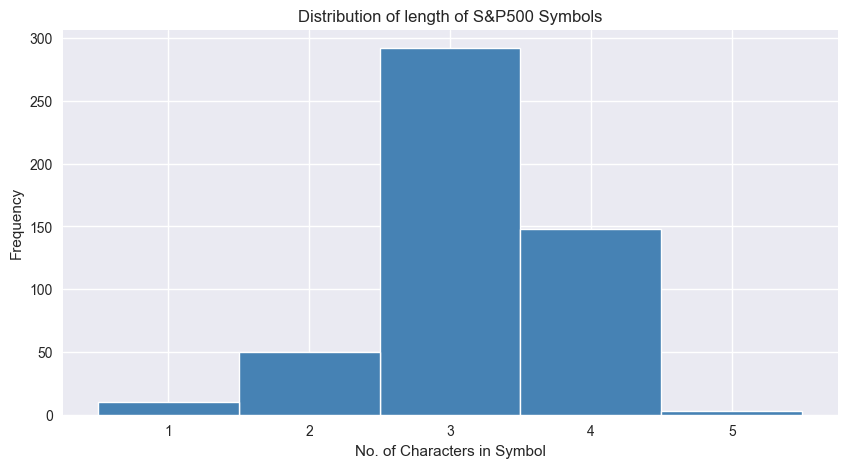

In [435]:
# getting distribution of length of each symbol in S&P500 companies
symbol_length = SnP500_final_cleaned.Symbol.str.len().value_counts()
x = symbol_length.index.array
y = symbol_length.array

# plotting bar chart with distribution with symbol length
fig, ax = plt.subplots()
ax.bar(x, y, width=1, edgecolor="white", color = "steelblue", linewidth=1)
ax.set_xlabel("No. of Characters in Symbol")
ax.set_ylabel("Frequency")
plt.title("Distribution of length of S&P500 Symbols")
plt.show()

In [436]:
# code to identify any symbols which may contain special characters or numbers
symbol_isalpha = SnP500_final_cleaned.Symbol.str.isalpha()
print(symbol_isalpha.value_counts())
print(SnP500_final_cleaned['Symbol'][symbol_isalpha==False])

True     501
False      2
Name: Symbol, dtype: int64
8      BRK.B
276     BF.B
Name: Symbol, dtype: object


As seen in the above figure, most S&P500 companies have symbol with 3 characters and ocassionaly rising up to 4. The maximum and minimum characters they can have are 5 and 1 respectively; however, very few companies fall into these extremes.

Moreover, most of S&P500 companies have a symbol made from alphabetical characters only. The 2 outliers which include a
period within the symbol are Berkshire Hathaway and Brown-Forman.

In [437]:
# checking if company names are unique
unique_companies = SnP500_final_cleaned.Company.nunique()
if unique_companies == len(SnP500_final_cleaned):
    print("All companies are unique")
else:
    print("There are duplicate company records")

All companies are unique


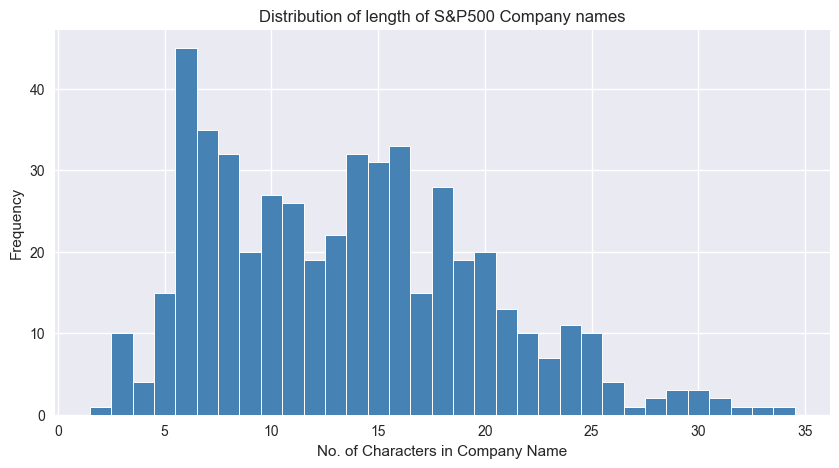

In [439]:
# plotting bar chart with distribution of company name length
symbol_length = SnP500_final_cleaned.Company.str.len().value_counts()
x = symbol_length.index.array
y = symbol_length.array
fig, ax = plt.subplots()
ax.bar(x, y, width=1, edgecolor="white", color = "steelblue", linewidth=0.7)
ax.set_xlabel("No. of Characters in Company Name")
ax.set_ylabel("Frequency")
plt.title("Distribution of length of S&P500 Company names")
plt.show()

In [440]:
# statistics for company name length
SnP500_final_cleaned.Company.str.len().describe()

count    503.000000
mean      13.514911
std        6.343368
min        2.000000
25%        8.000000
50%       13.000000
75%       18.000000
max       34.000000
Name: Company, dtype: float64

As seen in the above table, all S&P500 company names are unique. From the figure above, the distribution of the company name length looks to be positively skewed, with most frequent name length to be 6 characters and an mean length just above 13. This implies that S&P500 company names tend to be shorter in general.

### Columns: GICS Sector, HQ Country & HQ City/State

In [349]:
# distribution GISC Sector and percentages
print(f"Number of unique GISC: {SnP500_final_cleaned['GICS Sector'].nunique()}")
unique_GICS = pd.Series(SnP500_final_cleaned['GICS Sector'].value_counts(), name="Count")
percentage = pd.Series((unique_GICS/unique_GICS.sum())*100, name="Percentage")
df = pd.concat([unique_GICS,percentage], axis=1)
df.round(2)

Number of unique GISC: 11


,Count,Percentage
Industrials,77,15.31
Financials,72,14.31
Information Technology,64,12.72
Health Care,64,12.72
Consumer Discretionary,53,10.54
Consumer Staples,38,7.55
Real Estate,31,6.16
Utilities,30,5.96
Materials,29,5.77
Energy,23,4.57


As seen in the above table, the top 5 GICS sectors with the most S&P500 companies include Industrials, Financials, Information Technology, Health Care and Consumer Discretionary. It is expected that Industrials and Information Technology would have the most S&P500 companies as a result of acquiring wealth share from the 2nd and 3rd Industrial revolutions. With advances in Healthcare services in general, it is no surprise to see that it is in the top 5 GICS sectors. Consumer Discretionary involves business most senstive to economic cycles; for products it includes items such household durable goods and textiles/apparel and for services it includes leisure, hotels, restaurants etc. With the rise in entertainment and increasing emphasis on fashion, this is an industry which would be expected to contain some of the top S&P500 companies.

In [350]:
# distribution of HQ Countries and percentages
print(f"Number of unique HQ Countries: {SnP500_final_cleaned['HQ Country'].nunique()}")
unique_HQ_Country = pd.Series(SnP500_final_cleaned['HQ Country'].value_counts(), name="Count")
percentage = pd.Series((unique_HQ_Country/unique_HQ_Country.sum())*100, name="Percentage")
df = pd.concat([unique_HQ_Country,percentage], axis=1)
df.round(2)

Number of unique HQ Countries: 8


,Count,Percentage
United States,480,95.43
Ireland,9,1.79
United Kingdom,5,0.99
Switzerland,3,0.60
Netherlands,2,0.40
Bermuda,2,0.40
Canada,1,0.20
Israel,1,0.20


As seen in the above table, 95% of all S&P500 companies have HQ located in the United States which as expected. However, Ireland and the United Kingdom have combined majority of almost 3%. Companies located in Ireland could be because Ireland is considered as a 'tax haven' for large corporation in addition, the time zone difference to the States is not too different that work can be carried in sync. Companies located in the UK, could be also due to the time zone, but also because London is considered as one of the main financial hubs of the world, which could make it easy to access money when having large projects. 

In [443]:
# distribution of HQ State/City and percentages
print(f"Number of unique HQ States/Cities: {SnP500_final_cleaned['HQ State/City'].nunique()}")
unique_HQ_StateCity = SnP500_final_cleaned['HQ State/City'].value_counts()
percentage = pd.Series((unique_HQ_StateCity/unique_HQ_StateCity.sum())*100, name="Percentage")
df = pd.concat([unique_HQ_StateCity,percentage], axis=1)
df.round(2).head(10)

Number of unique HQ States/Cities: 51


,HQ State/City,Percentage
California,68,13.52
New York,52,10.34
Texas,46,9.15
Illinois,33,6.56
Massachusetts,23,4.57
Ohio,20,3.98
Pennsylvania,19,3.78
Georgia,18,3.58
Florida,16,3.18
Washington,15,2.98


As seen in the above table the top 10 HQ locations for S&P500 companies are in the United States, with the top 3 states being California, New York and Texas. The 3 states are expected because Silicon Valley is located in California and hence many tech and financial companies would be located there to access of skilled worker and resources. Many of the S&P500 companies, especially in financial sector, would be located in New York due historical reasons such as: access to skilled workers, access to capital, good transportation, networking opportunities. Texas is also another 'tax haven' for corporations and their founders, hence many big companies would be expected to locate there.

(0.0, 100.0)

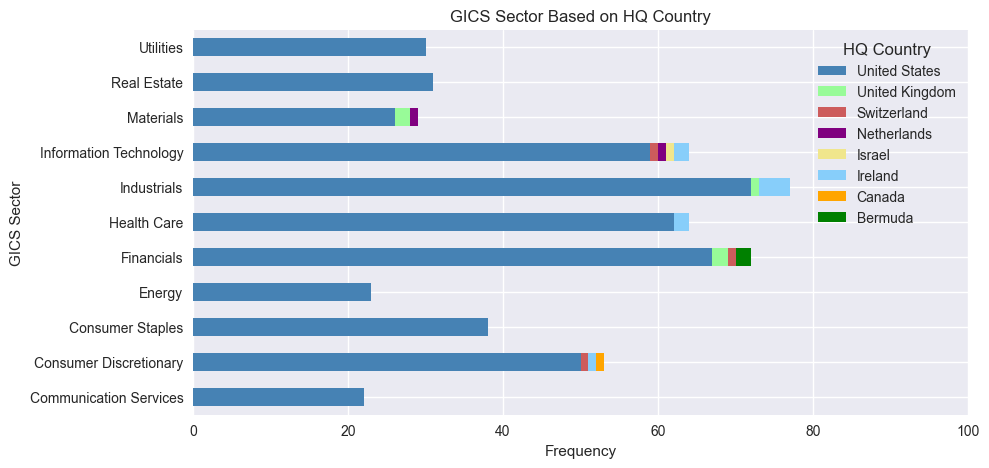

In [455]:
# linking HQ Country with GICS sector
table = SnP500_final_cleaned[['GICS Sector','HQ Country']].groupby(by=['GICS Sector']).value_counts()
table = pd.pivot_table(SnP500_final_cleaned[['GICS Sector','HQ Country']], values='HQ Country', index=['GICS Sector'],
                       columns=['HQ Country'], aggfunc="value_counts")
table = table.reindex(sorted(table.columns, reverse=True), axis=1)
ax = table.plot.barh(stacked=True, color={
    "United States": "steelblue",
    "United Kingdom": "palegreen",
    "Switzerland": "indianred", 
    "Netherlands": "purple",
    "Israel": "khaki", 
    "Ireland":"lightskyblue", 
    "Canada": "orange",
    "Bermuda": "green"})

ax.set_title('GICS Sector Based on HQ Country')
ax.set_xlabel("Frequency")
ax.set_xlim(0,100)

As seen in the above bar chart, most of these sectors are dominated by companies located in the United States. Utilities, Real Estate, Energy, Consumer Staples and Communication Services are GICS sectors where none of the companies are located outside of the United States. S&P500 companies located in the UK are primarily split across Materials and Financials, with some involvement in Industrials. S&P500 companies in Ireland are split across Information Technology, Industrials, Health Care and Consumer Discretionary.

### Columns: Market Cap, Revenue, Profit Margin, Earnings per Share & Price to Earning ratio

In [444]:
# statiscal summary of all numerical feature
df = SnP500_final_cleaned[['Market Cap / B', 'Revenue (TTM) / B', 'Profit Margin / %', 'Earnings per Share (TTM) / $', 'Price to Earning ratio (TTM)']]
stats_summary = df.describe()
df.describe()

,Market Cap / B,Revenue (TTM) / B,Profit Margin / %,Earnings per Share (TTM) / $,Price to Earning ratio (TTM)
count,503.000000,503.000000,503.000000,503.000000,503.000000
mean,84.608847,32.370596,13.672266,7.875030,26.131849
std,240.811698,64.245931,15.026608,23.830617,31.205162
min,4.560000,0.730000,-165.730000,-28.880000,-230.120000
25%,16.505000,6.050000,6.975000,2.160000,12.890000
50%,31.230000,12.710000,11.910000,4.900000,22.410000
75%,65.295000,27.275000,20.595000,8.545000,32.680000
max,3020.000000,638.790000,87.170000,474.980000,294.790000


There are some key statistics in the above table which suggest the possiblity of outliers due to errors. These statistics are:
- max value in ***Market Cap***
- min values in ***Profit Margin***, ***Earnings per Share*** and ***Price to Earning ratio***

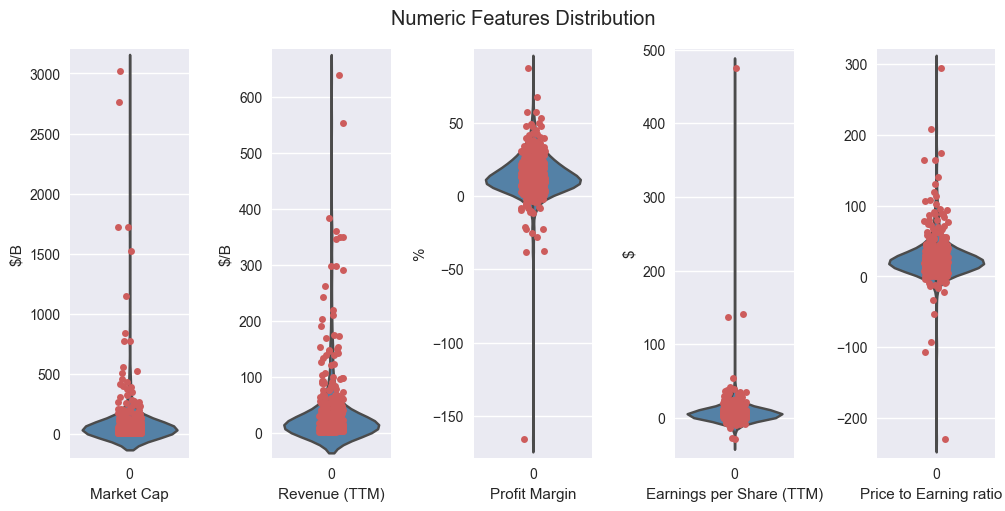

In [467]:
# plotting violin plot to visualise distribution and stripplot to view outliers
fig, ax = plt.subplots(nrows=1, ncols=5)
fig.tight_layout()
for i, column in enumerate(list(df.columns)):
    plt.subplot(1,5,(i+1))
    if column[-1]=="B":
        units = "$/B"
    elif column[-1]==")":
        units=""
    else:
        units = column[-1]
    sns.violinplot(data = SnP500_final_cleaned[column], color = "steelblue")
    sns.stripplot(data = SnP500_final_cleaned[column], color = "indianred")
    ax[i].set_xlabel(column[:-4])
    ax[i].set_ylabel(units)

ax[0].set_ylim(-200,3200)
ax[1].set_ylim(-45,685)
plt.suptitle("Numeric Features Distribution")
plt.subplots_adjust(top=0.9, wspace=0.7)

In [420]:
# using 3 sigma rule to identify outliers and then highlighting the companies, GICS sector and value to confirm if outlier
# is due to any error in data
outlier = []
cumulative_outlier_cat = []
for column in list(df.columns):
    std = stats_summary[column][2]
    upper_limit = 3*std
    lower_limit = -3*std
    cond1 = SnP500_final_cleaned[column]>upper_limit
    cond2 = SnP500_final_cleaned[column]<lower_limit
    add_company = SnP500_final_cleaned['Company'][cond1|cond2]
    add_GICS = SnP500_final_cleaned['GICS Sector'][cond1|cond2]
    print(SnP500_final_cleaned[['Company','GICS Sector', column]][cond1|cond2])
    outlier.extend(add_company)
    cumulative_outlier_cat.extend(add_GICS)

                   Company             GICS Sector  Market Cap / B
0               Apple Inc.  Information Technology         3020.00
1                Microsoft  Information Technology         2760.00
2  Alphabet Inc. (Class C)  Communication Services         1720.00
3  Alphabet Inc. (Class A)  Communication Services         1720.00
4                   Amazon  Consumer Discretionary         1520.00
5                   Nvidia  Information Technology         1150.00
6           Meta Platforms  Communication Services          839.32
7              Tesla, Inc.  Consumer Discretionary          771.33
8       Berkshire Hathaway              Financials          768.94
                     Company             GICS Sector  Revenue (TTM) / B
0                 Apple Inc.  Information Technology             383.29
1                  Microsoft  Information Technology             218.31
2    Alphabet Inc. (Class C)  Communication Services             297.13
3    Alphabet Inc. (Class A)  Communicatio

# TODO

In [446]:
# checking if there are any recurring outliers
outlier = pd.Series(outlier)
unique_counts_outlier = outlier.value_counts()
unique_counts_outlier.head(10)

Apple Inc.                 2
Alphabet Inc. (Class C)    2
Alphabet Inc. (Class A)    2
Amazon                     2
Microsoft                  2
Berkshire Hathaway         2
Cardinal Health            2
Palo Alto Networks         1
Booking Holdings           1
AutoZone                   1
dtype: int64

As seen in the above table, the top 5 companies which are identified as being outliers in 2 of the 5 numerical features, are in fact the top 5 S&P500 companies. This suggests that their values of Market Capitalisation and Revenue are well above of what is expected from a typical S&P500 company.

In [448]:
# identifying from which GICS sector do these outliers come from
cumulative_outlier_cat = pd.Series(cumulative_outlier_cat)
unique_counts_outlier_cat = cumulative_outlier_cat.value_counts()
print(unique_counts_outlier_cat)

Information Technology    11
Consumer Discretionary     9
Health Care                9
Communication Services     6
Financials                 5
Industrials                4
Real Estate                4
Consumer Staples           3
Energy                     3
dtype: int64


# TODO As seen in the above table, 4 of top 5 GICS sector which contain 

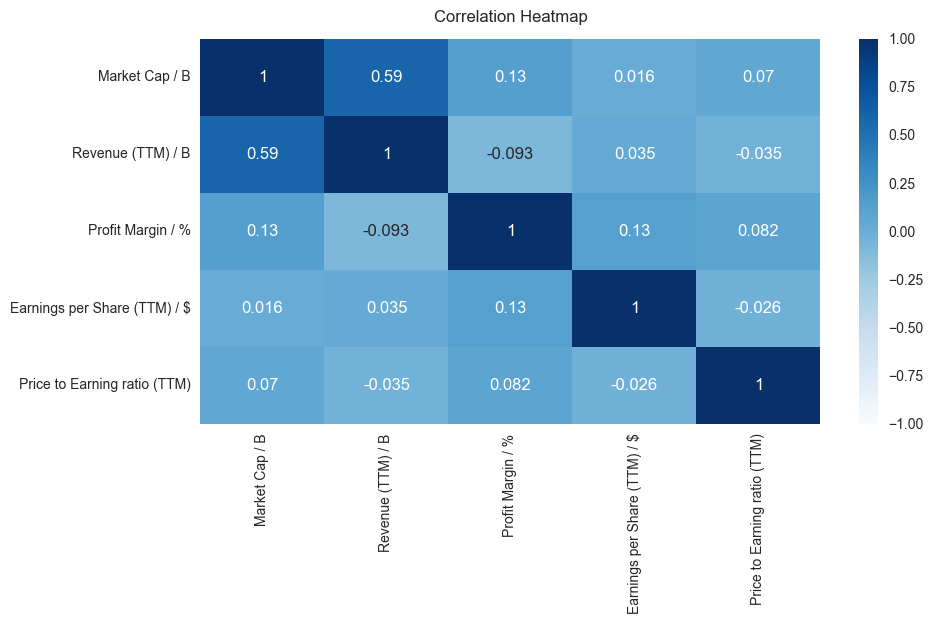

In [219]:
# identifying correlation between the numerical features
df.corr()
plt.figure(figsize=(10, 5))
sns.color_palette("Blues", as_cmap=True)
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap = "Blues")
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

## Step 4: Investigating Data-Set with questions
***

## Step 5: Conclusion
***
[TODO placeholder]